In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import l1_min_c
from sklearn.linear_model import LogisticRegression
import numpy as np
from copy import deepcopy
from utils import plot_fs

/home/appuser/.local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# Load training sets for WoE and mean transformations
X_train_WOE = pd.read_csv('data/X_train_WOE.csv',index_col=0)
X_train_mean = pd.read_csv('data/X_train_mean.csv',index_col=0) 
y_train = pd.read_csv('data/y_train.csv',index_col=['ID']).squeeze()

In [3]:
# Initialization  
eps = np.finfo(float).eps
n_train = y_train.shape[0]
results_boostrap = dict()
# Define range of the regularization parameter 
cs_dict = {'WOE':l1_min_c(X_train_WOE, y_train.reset_index(drop=True), loss="log") * np.logspace(0, 10, 1000),
           'MEAN':l1_min_c(X_train_mean, y_train.reset_index(drop=True), loss="log") * np.logspace(0, 10, 1000)}

In [4]:
# Feature selection procedure for WOE and mean imputation
seed = 123
y_train_ = y_train.astype(int).reset_index(drop=True)
data_dict = {'WOE':X_train_WOE,
                'MEAN':X_train_mean}
results = dict()
for j,data_name in enumerate(['WOE','MEAN']):
    X_train_ = data_dict[data_name]
    cs = cs_dict[data_name]
    clf = LogisticRegression(
        class_weight='balanced',
        penalty="l1",
        solver="saga",
        tol=1e-6,
        max_iter=int(1e6),
        warm_start=True,
        random_state=seed,
    )
    n_coefs_ = []
    weights_ = []
    clfs_ = []
    ll_ = []
    for c in cs:
        clf.set_params(C=c)
        clf.fit(X_train_, y_train_)
        clf_weights = clf.coef_.ravel().copy()
        k = np.count_nonzero(clf_weights)
        p = np.clip(clf.predict_proba(X_train_),eps,1)
        ll = (y_train_*np.log(p[:,1])+(1-y_train_)*np.log(p[:,0])).sum()
        clfs_.append(deepcopy(clf))
        weights_.append(clf_weights)
        n_coefs_.append(k)
        ll_.append(ll)
    K_ = np.array(n_coefs_)+1
    LL_ = np.array(ll_)
    results.update({data_name:{
        'n_coefs' : np.array(n_coefs_),
        'weights' : np.array(weights_),
        'clfs' : clfs_, 
        'll' : LL_,
        'aic' : -2*LL_ + 2*K_,
        'aicc' : -2*LL_ + 2*K_ + (2*K_*(K_+1))/(n_train-K_-1),
        'bic' : -2*LL_ + np.log(n_train)*(K_),
        'cs': cs
    }})
results_boostrap.update({'0':results})

Text(0.5, 0, '$1/\\lambda$')

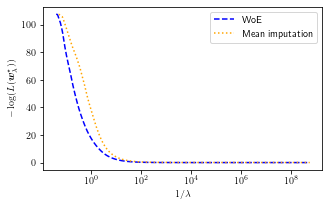

In [6]:
# Plot log likelihood vs regularization parameter
fig_ll,ax_ll = plot_fs(results_boostrap,cs_dict,'ll',reverse=True)
ax_ll.set_ylabel(r"$-\log(L(\boldsymbol{w}_{\lambda}^{\star}))$")
ax_ll.set_xlabel(r"$1/\lambda$")

Text(0.5, 0, '$1/\\lambda$')

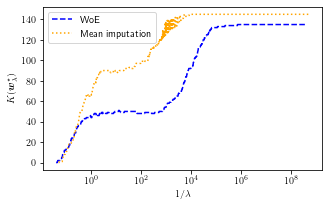

In [9]:
# Plot cardinality non-zero coefficients vs regularization parameter
fig_K,ax_K = plot_fs(results_boostrap,cs_dict,'n_coefs')
ax_K.set_ylabel(r"$K(\boldsymbol{w}^{\star}_{\lambda})$")
ax_K.set_xlabel(r"$1/\lambda$")

Text(0.5, 0, '$1/\\lambda$')

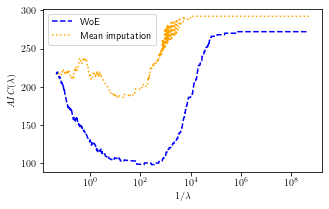

In [12]:
# Plot cardinality AIC vs regularization parameter
fig_aic,ax_aic = plot_fs(results_boostrap,cs_dict,'aic')
ax_aic.set_ylabel(r"$AIC(\lambda)$")
ax_aic.set_xlabel(r"$1/\lambda$")

Text(0.5, 0, '$1/\\lambda$')

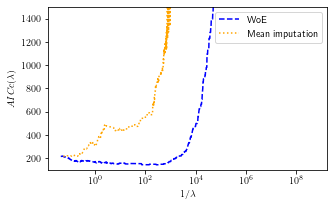

In [16]:
# Plot cardinality AICc vs regularization parameter
fig_aicc,ax_aicc = plot_fs(results_boostrap,cs_dict,'aicc')
ax_aicc.set_ylim(100,1500)
ax_aicc.set_ylabel(r"$AICc(\lambda)$")
ax_aicc.set_xlabel(r"$1/\lambda$")